In [1]:
import pandas as pd
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

Using TensorFlow backend.


In [2]:
data = pd.read_csv('normalize_combi_with_stopwords.csv')

In [4]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
train.shape , test.shape
le = LabelEncoder()
train['sentiment_class'] = le.fit_transform(train['sentiment_class'])
train.head()

combi = train.append(test, ignore_index=True) 
combi.drop(['id','lang','retweet_count','original_author'],axis=1,inplace=True)
combi.shape

((3235, 6), (1387, 5))

In [3]:
data.head(3)

,tweet,label
0,happy mothersday to all you amaze mother out t...,0.0
1,happy mother day mum i be sorry i can not be t...,0.0
2,happy mother day to all this do a mother days ...,-1.0


In [4]:
l = LabelEncoder()
data['label'] = l.fit_transform(data['label'])
data.head(3)

,tweet,label
0,happy mothersday to all you amaze mother out t...,1
1,happy mother day mum i be sorry i can not be t...,1
2,happy mother day to all this do a mother days ...,0


In [5]:
train_df = data.iloc[:3235,:]
test_df =data.iloc[3235:,:]
train_df.shape , test_df.shape

((3235, 2), (1387, 2))

In [6]:
train_df['label'].value_counts()

1    1701
0     769
2     765
Name: label, dtype: int64

In [7]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("d:/NLP/cs224/glove.6B.100d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)
## Check function
x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
x_test_sample = ["I’m creating a macro and need some text for testing purposes", "I’m designing a document and don’t want to get bogged down in what the text actually says"]
X_train_Glove_s, X_test_Glove_s, word_index_s, embeddings_dict_s = prepare_model_input(x_train_sample, x_test_sample, 100, 20)
print("\n X_train_Glove_s \n ", X_train_Glove_s)
print("\n X_test_Glove_s \n ", X_test_Glove_s)
print("\n Word index of the word testing is : ", word_index_s["testing"])
print("\n Embedding for thw word want \n \n", embeddings_dict_s["want"])

Found 51 unique tokens.
(4, 20)
Total 400000 word vectors.

 X_train_Glove_s 
  [[ 0  0  0  0  0  0  0  0  8  9  5 10 11  2  6  3 12  4 13 14]
 [17 18 19  1 20 21 22 23 24  3 25 26  6  1 27 28 29 30 31 32]]

 X_test_Glove_s 
  [[ 0  0  0  0  0  0  0  0  0  7 33  1 34  4 35 36  2 37 38 39]
 [ 0  0  0  7 40  1 41  4 42 43 44 45 46 47 48 49  3  2 50 51]]

 Word index of the word testing is :  38

 Embedding for thw word want 
 
 [-1.7124e-01  5.6447e-01  3.4667e-01 -5.6711e-01 -6.5675e-01  1.2081e-01
 -7.6863e-01  7.2832e-02  4.2237e-01 -1.0464e-01 -9.5098e-02  3.5531e-01
  3.7523e-01 -1.0315e-01 -3.6373e-01 -3.4235e-01  1.5421e-01  4.2595e-01
 -9.3621e-01  7.6463e-01  2.2936e-01  3.9153e-01  4.8629e-02 -6.3902e-01
 -2.7606e-01  1.4309e-01 -1.4570e-01 -9.2603e-01  7.3662e-01 -4.7586e-01
  1.6671e-01  8.7328e-01  4.3905e-02 -2.1803e-03  6.0981e-01  1.8376e-01
  1.7213e-01  2.4313e-01  3.1518e-01 -4.9676e-01 -3.4410e-01 -1.8998e-01
  1.4180e-01 -1.0103e+00 -6.8090e-01 -1.6667e-01 -3.8716e-0

In [8]:
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=100, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    
    # Initialize a sequential model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [9]:
X = train_df.tweet
y = train_df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 3)
model.summary()

Preparing model input ...
Found 12882 unique tokens.
(3235, 500)
Total 400000 word vectors.
Done!
Building Model!
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1288300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 64)           34048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 64)           24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 64)           24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 64)           0         
__________

In [10]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# for glove 100d

In [11]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=3,
                           batch_size=128,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 2588 samples, validate on 647 samples
Epoch 1/3
2588/2588 [==============================] - 115s 44ms/step - loss: 1.0411 - acc: 0.5143 - val_loss: 1.0194 - val_acc: 0.5363
Epoch 2/3
2588/2588 [==============================] - 95s 37ms/step - loss: 1.0281 - acc: 0.5232 - val_loss: 1.0176 - val_acc: 0.5363
Epoch 3/3
2588/2588 [==============================] - 94s 36ms/step - loss: 1.0286 - acc: 0.5232 - val_loss: 1.0160 - val_acc: 0.5363


# for glove 50d

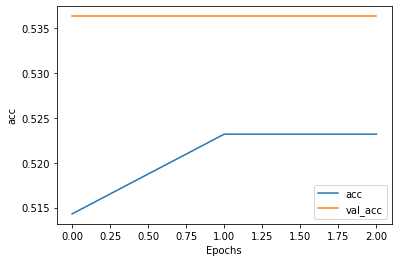

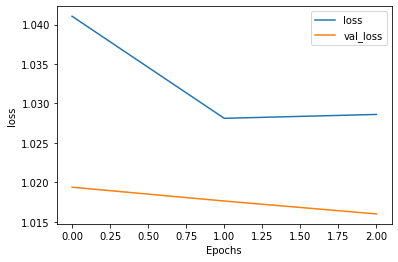

In [12]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [33]:
test_df.tail(5),test_df.shape

(                                                  tweet  label
 4617  happy mother s day you crazy bitch i be sorry ...    459
 4618  mum can not get to the bingo so we bring the b...    458
 4619  despite all this bullshit today have be one of...    457
 4620  happy mother day firstly to my queen daniele_s...    930
 4621  mother day walk when you live in a tiny villag...   1389, (1387, 2))

In [34]:
X = test_df.tweet
y = test_df.label
x1, x2, y_train, y_test = train_test_split(X, y, test_size = 0.2)
x1, x2, word_index, embeddings_dict = prepare_model_input(x1,x2)

Found 6863 unique tokens.
(1387, 500)
Total 400000 word vectors.


In [14]:
MAX_NB_WORDS=75000
MAX_SEQUENCE_LENGTH=500
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts = test_df['tweet'])
test_text = tokenizer.texts_to_sequences(texts = test_df['tweet'])

test_text = pad_sequences(sequences = test_text, maxlen = MAX_SEQUENCE_LENGTH)

print(test_text.shape)

(1387, 500)


In [15]:
pred = model.predict_classes(test_text)

In [19]:
type(pred)

numpy.ndarray

In [22]:
pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [20]:
pred1 = l.inverse_transform(pred)
type(pred1)

numpy.ndarray

In [21]:
pred1

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
test = pd.read_csv('dataset/test.csv')
test['sentiment_class'] = pred1
submission = test[['id','sentiment_class']] 
submission.to_csv('bilstm.csv', index=False)

In [28]:
pre =model.predict_classes(X_test_Glove)

In [30]:
from sklearn.metrics import f1_score
f1_score(y_test,pre ,average='weighted')

C:\Users\DELL\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3744538327336507